In [1]:
# ===============================================================
#  MIXTURE OF EXPERTS (MoE) FOR METRIC LEARNING SCORE PREDICTION
# ===============================================================
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import json
from tqdm import tqdm
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import KernelPCA
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import root_mean_squared_error
from sklearn.calibration import CalibratedClassifierCV
from sklearn.isotonic import IsotonicRegression
from cuml import Ridge
import lightgbm as lgb
import torch

In [3]:
print(f"PyTorch Version: {torch.__version__}")
print(f"PyTorch CUDA Version: {torch.version.cuda}")
print(f"Is CUDA available? {torch.cuda.is_available()}")

# Set up device (use GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

PyTorch Version: 2.8.0+cu126
PyTorch CUDA Version: 12.6
Is CUDA available? True
Using device: cuda


In [16]:
# Load data print("Loading data files...") 
train = json.load(open("data/train_data.json")) 
test = json.load(open("data/test_data.json")) 
metric_embs = np.load(open("data/metric_name_embeddings.npy", "rb")) 
metric_names = json.load(open("data/metric_names.json"))

aug = []
for item in train:
    if (np.random.random() > 0.6):
        m = np.random.choice(metric_names)
        # score = np.round(np.random.normal(loc=1, scale=1.5), 0)  # low score bias
        score = 0.0
        aug.append({
            "system_prompt": item.get("system_prompt") or "",
            "user_prompt": item["user_prompt"],
            "response": item["response"],
            "metric_name": m,
            "score": score
        })

train_aug = train + aug
print(f"Total data points: {len(train_aug)}")

sbert_model = SentenceTransformer("l3cube-pune/indic-sentence-similarity-sbert", device="cuda")
X_train = []
y = []
for r in tqdm(train_aug):
    txt = f"{r.get('system_prompt', '')} [SEP] {r.get('user_prompt', '')} [SEP] {r.get('response', '')}"
    text_emb = sbert_model.encode(txt, normalize_embeddings=True)
    metric_emb = metric_embs[metric_names.index(r['metric_name'])]
    X_train.append(np.concatenate([text_emb, metric_emb]))
    y.append(r['score'])

X_train = np.array(X_train, dtype=np.float32)
y = np.array(y, dtype=np.float32)

np.save("data/X_train_augmented.npy", X_train)
np.save("data/y_train_augmented.npy", y)

Total data points: 6996


100%|██████████| 6996/6996 [00:56<00:00, 124.86it/s]


In [20]:
X_test = []
for r in tqdm(test):
    txt = f"{r.get('system_prompt', '')} [SEP] {r.get('user_prompt', '')} [SEP] {r.get('response', '')}"
    text_emb = sbert_model.encode(txt, normalize_embeddings=True)
    metric_emb = metric_embs[metric_names.index(r['metric_name'])]
    X_test.append(np.concatenate([text_emb, metric_emb]))

X_test = np.array(X_test, dtype=np.float32)
np.save("data/X_test_augmented.npy", X_test)

100%|██████████| 3638/3638 [00:29<00:00, 123.57it/s]


Score Statistics:
Min: 0.0
Max: 10.0
Mean: 9.1195
Std: 0.94232154


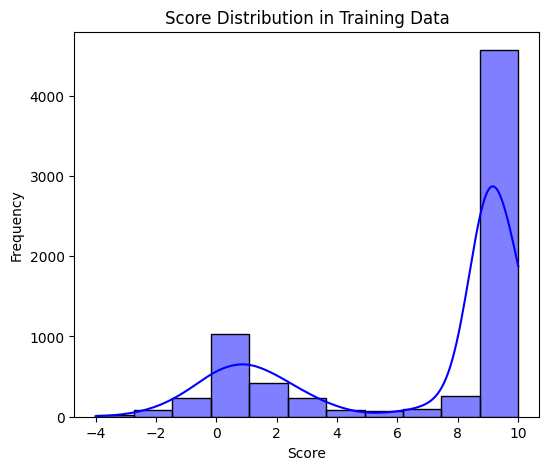

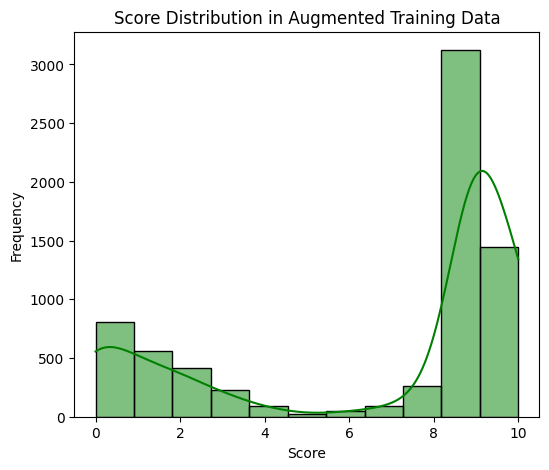

In [5]:
# Load Original Data
y_original = np.load("data/y_train_original.npy")
X_test = np.load("data/X_test.npy")
# Score Statistics
print("Score Statistics:")
print("Min:", np.min(y_original))
print("Max:", np.max(y_original))
print("Mean:", np.mean(y_original))
print("Std:", np.std(y_original))
# Score Distribution Visualization
plt.figure(figsize=(6, 5))
sns.histplot(y, bins=11, kde=True, color='blue')
plt.title("Score Distribution in Training Data")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.show()

# Score Distribution after Augmentation
train_aug_df = pd.DataFrame(train_aug)
y_aug = np.clip(np.array(train_aug_df['score'], dtype=np.float32), 0, 10)
plt.figure(figsize=(6, 5))
sns.histplot(y_aug, bins=11, kde=True, color='green')
plt.title("Score Distribution in Augmented Training Data")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.show()

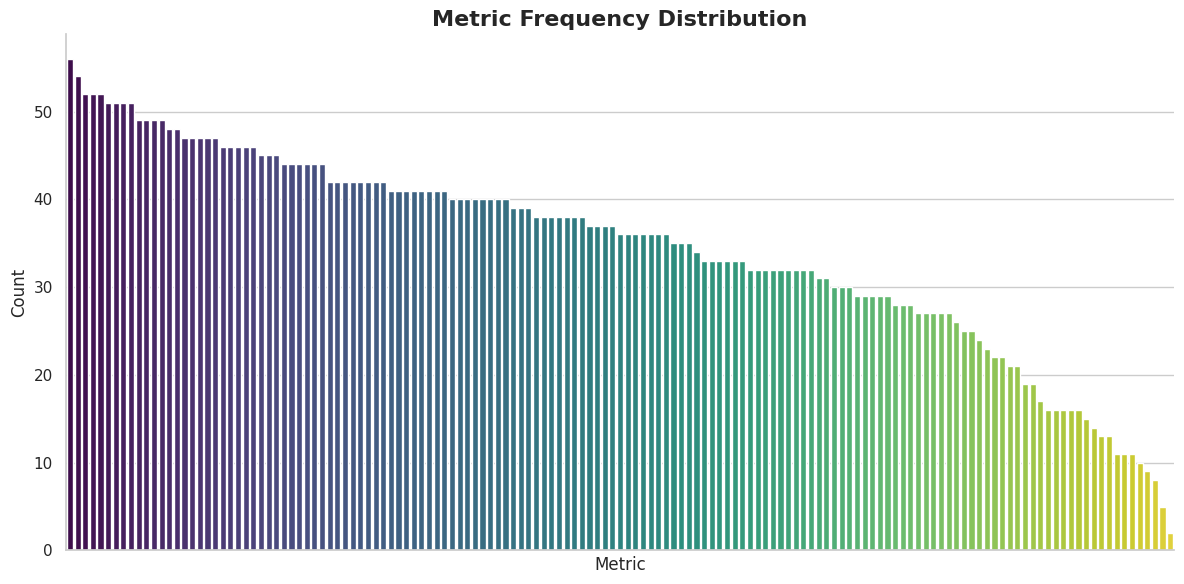

In [6]:
train_df = pd.read_json("data/train_data.json")
metrics = train_df['metric_name'].value_counts().reset_index()

# Sort by count descending
metrics = metrics.sort_values("count", ascending=False)

# Nice seaborn style
sns.set_theme(style="whitegrid")

plt.figure(figsize=(12, 6))

sns.barplot(
    data=metrics,
    x='metric_name',
    y='count',
    palette="viridis"  # beautiful gradient palette
)

plt.title("Metric Frequency Distribution", fontsize=16, weight='bold')
plt.xlabel("Metric", fontsize=12)
plt.ylabel("Count", fontsize=12)

# Hide labels because 114 labels are unreadable
plt.xticks([], [])

# Remove spines for cleaner look
sns.despine()

plt.tight_layout()
plt.show()

In [9]:
# -------------------------------------------------------------
# LOAD DATA
# -------------------------------------------------------------
print("Loading data files...")
train_aug = pd.DataFrame(train_aug)
test  = pd.DataFrame(test)

metric_name_to_idx = {name: i for i, name in enumerate(metric_names)}

# -------------------------------------------------------------
# BUILD text and metric index columns
# -------------------------------------------------------------
def combine_text(row):
    return " ".join([
        row.get("system_prompt") or "",
        row.get("user_prompt") or "",
        row.get("response") or "",
    ]).strip()


train_aug["metric_idx"] = train_aug["metric_name"].map(metric_name_to_idx)
test["metric_idx"] = test["metric_name"].map(metric_name_to_idx)

train_aug["text"] = train_aug.apply(combine_text, axis=1)
test["text"]  = test.apply(combine_text, axis=1)

X_train_text = np.load("data/X_train_augmented.npy")
y = np.load("data/y_train_augmented.npy")
X_test_text = np.load("data/X_test_augmented.npy")

Loading data files...


In [28]:
# -------------------------------------------------------------
# FEATURE ENGINEERING
# -------------------------------------------------------------
print("Generating numeric features...")

def simple_tokens(s):
    if not isinstance(s, str):
        return []
    return str(s).lower().split()


for df in [train_aug, test]:

    df["len_user"] = df["user_prompt"].fillna("").apply(lambda x: len(str(x)))
    df["len_resp"] = df["response"].fillna("").apply(lambda x: len(str(x)))
    df["len_sys"]  = df["system_prompt"].fillna("").apply(lambda x: len(str(x)))
    df["len_text"] = df["text"].apply(len)

    df["tok_user"] = df["user_prompt"].fillna("").apply(lambda x: len(str(x).split()))
    df["tok_resp"] = df["response"].fillna("").apply(lambda x: len(str(x).split()))
    df["tok_sys"]  = df["system_prompt"].fillna("").apply(lambda x: len(str(x).split()))

    df["ratio_len_resp_user"] = df["len_resp"] / (df["len_user"] + 1)
    df["ratio_tok_resp_user"] = df["tok_resp"] / (df["tok_user"] + 1)

    df["metric_text"] = df["metric_idx"].apply(lambda x: metric_names[x])

    df["metric_tokens"] = df["metric_text"].apply(simple_tokens)
    df["resp_tokens"] = (df["user_prompt"].fillna("") + " " +
                         df["response"].fillna("")).apply(simple_tokens)

    def overlap_feats(row):
        ms = set(row["metric_tokens"])
        rs = set(row["resp_tokens"])
        inter = len(ms & rs)
        union = len(ms | rs) if (ms or rs) else 1
        return pd.Series({
            "metric_tok_count": len(ms),
            "resp_tok_count": len(rs),
            "overlap_count": inter,
            "overlap_frac_metric": inter / max(len(ms), 1),
            "overlap_frac_resp": inter / max(len(rs), 1),
            "overlap_jaccard": inter / union,
            "has_metric_in_resp": 1.0 if inter > 0 else 0.0,
        })

    feats = df.apply(overlap_feats, axis=1)
    df[[
        "metric_tok_count", "resp_tok_count", "overlap_count",
        "overlap_frac_metric", "overlap_frac_resp",
        "overlap_jaccard", "has_metric_in_resp"
    ]] = feats


# -------------------------------------------------------------
# NUMERIC FEATURE LIST
# -------------------------------------------------------------
num_features = [
    "len_user", "len_resp", "len_sys", "len_text",
    "tok_user", "tok_resp", "tok_sys",
    "ratio_len_resp_user", "ratio_tok_resp_user",
    "metric_tok_count", "resp_tok_count", "overlap_count",
    "overlap_frac_metric", "overlap_frac_resp",
    "overlap_jaccard", "has_metric_in_resp",
]

X_num_train = np.array(train_aug[num_features], dtype=np.float32)
X_num_test = np.array(test[num_features], dtype=np.float32)
# -------------------------------------------------------------
# BUILD FINAL X_train and X_test
# -------------------------------------------------------------
X_train = np.hstack([X_num_train, X_train_text])
X_test  = np.hstack([X_num_test, X_test_text])

print("Feature matrix shapes:")
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)

Generating numeric features...
Feature matrix shapes:
X_train: (7001, 1552)
X_test: (3638, 1552)


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from sentence_transformers import SentenceTransformer


print("Loading data files...")
train = json.load(open("data/train_data.json"))
metric_embs = np.load(open("data/metric_name_embeddings.npy", "rb"))
metric_names = json.load(open("data/metric_names.json"))


# -----------------------------
# Build base text, metric-id, score
# -----------------------------
text_list, metric_list, score_list = [], [], []
metric_name_to_idx = {name: i for i, name in enumerate(metric_names)}

for item in train:
    text = " ".join([
        item.get("system_prompt") or "",
        item.get("user_prompt") or "",
        item.get("response") or ""
    ]).strip()
    
    text_list.append(text)
    metric_list.append(metric_name_to_idx[item["metric_name"]])
    score_list.append(item["score"])

text_list = np.array(text_list)
metric_list = np.array(metric_list)
score_list = np.array(score_list)


# -------------------------------------------------------------
# Random negatives
# -------------------------------------------------------------
def random_negative_sampling(text, metric, n_samples=2000):
    n = len(text)
    neg_samples = []

    for _ in range(n_samples):
        i = np.random.randint(n)
        j = np.random.randint(n)
        while j == i:
            j = np.random.randint(n)

        neg_samples.append((text[i], metric[j], 0.0))
    return neg_samples


# -------------------------------------------------------------
# Text embeddings
# -------------------------------------------------------------
encoder = SentenceTransformer("l3cube-pune/indic-sentence-similarity-sbert", device="cuda")

print("Encoding training text...")
text_embs = encoder.encode(text_list, show_progress_bar=True)


# -------------------------------------------------------------
# Hard negatives
# -------------------------------------------------------------
def hard_negative_mining(text_list, metric_embs, true_metric_list, n_samples=2000, top_k=5):
    """
    Hard negatives = pick top-k similar mismatched metrics
    """
    print("Computing similarity matrix...")
    
    sim = cosine_similarity(text_embs, metric_embs)
    
    # Normalize similarity for more stable thresholding
    scaler = StandardScaler()
    sim_scaled = scaler.fit_transform(sim)
    
    n_text, n_metrics = sim_scaled.shape
    hard_neg = []

    for _ in range(n_samples):
        i = np.random.randint(n_text)
        true_idx = true_metric_list[i]
        
        # similarities to all metrics
        row = sim_scaled[i].copy()
        
        # mask out true metric
        row[true_idx] = -999  

        # pick top-k hardest (most similar) mismatches
        hard_candidates = np.argsort(row)[::-1][:top_k]

        j = np.random.choice(hard_candidates)

        hard_neg.append((text_list[i], j, 0.0))

    return hard_neg


# -------------------------------------------------------------
# Generate augmented samples
# -------------------------------------------------------------
print("Generating augmented data...")

random_negs = random_negative_sampling(text_list, metric_list, n_samples=2000)
hard_negs = hard_negative_mining(text_list, metric_embs, metric_list, n_samples=2000)

aug = random_negs + hard_negs

print(f"Generated {len(aug)} augmented samples.")


# -------------------------------------------------------------
# Build Final X_train and y_train
# -------------------------------------------------------------

X_text = []
X_metric = []
y_final = []

# Original
for t, m, s in zip(text_list, metric_list, score_list):
    X_text.append(t)
    X_metric.append(m)
    y_final.append(s)

# Augmented
for t, m, s in aug:
    X_text.append(t)
    X_metric.append(m)
    y_final.append(s)

X_text = np.array(X_text)
X_metric = np.array(X_metric)
y_final = np.array(y_final)

print("Final training sizes:")
print("X_text:", X_text.shape)
print("X_metric:", X_metric.shape)
print("y:", y_final.shape)


In [ ]:
sbert_model = SentenceTransformer("l3cube-pune/indic-sentence-similarity-sbert", device="cuda")
X_train = []
y = []

for r in range(len(X_text)):
    text_emb = sbert_model.encode(X_text[r], normalize_embeddings=True)
    metric_emb = metric_embs[X_metric[r]]
    X_train.append(np.concatenate([text_emb, metric_emb]))

    y.append(float(y_final[r]))

X_train = np.array(X_train, dtype=np.float32)
y = np.array(y, dtype=np.float32)
print("Test data preparation complete.")
# Save the prepared datasets as embeddings
np.save("data/X_train_augmented.npy", X_train)
np.save("data/y_train_augmented.npy", y)

Training set: (6996, 1536) Test set: (3638, 1536)


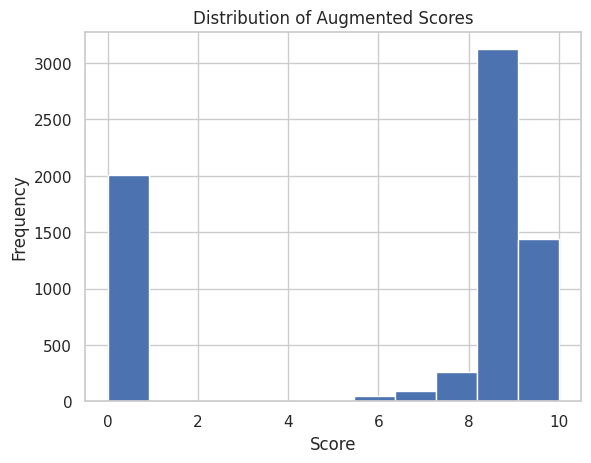

In [17]:
# ---------------------------------------------------------------
# Load data
# ---------------------------------------------------------------
X = np.load("data/X_train_augmented.npy")
y = np.load("data/y_train_augmented.npy")
X_test = np.load("data/X_test_augmented.npy")

print("Training set:", X_train.shape, "Test set:", X_test.shape)

# KDE plot for scores
y_s = pd.Series(y)
y_s.hist(bins=11)
plt.title("Distribution of Augmented Scores")
plt.xlabel("Score") 
plt.ylabel("Frequency")
plt.show()

In [18]:
y_s.value_counts()

9.0     3123
0.0     2009
10.0    1442
8.0      259
7.0       95
6.0       45
3.0        7
1.0        6
2.0        5
4.0        3
5.0        1
9.5        1
Name: count, dtype: int64

In [19]:
# ---------------------------------------------------------------
# Split text embedding & metric embedding
# ---------------------------------------------------------------
d = X.shape[1] // 2
text = X[:, :d].astype(np.float32)
metric = X[:, d:].astype(np.float32)

text_test = X_test[:, :d].astype(np.float32)
metric_test = X_test[:, d:].astype(np.float32)


# ---------------------------------------------------------------
# IMPROVED: More comprehensive feature engineering
# ---------------------------------------------------------------
def build_enhanced_features(text_emb, metric_emb):
    """Build richer interaction features"""
    
    # Normalize embeddings
    text_norm = text_emb / (np.linalg.norm(text_emb, axis=1, keepdims=True) + 1e-9)
    metric_norm = metric_emb / (np.linalg.norm(metric_emb, axis=1, keepdims=True) + 1e-9)
    
    # Basic similarity metrics
    cos = np.sum(text_norm * metric_norm, axis=1)
    dot = np.sum(text_emb * metric_emb, axis=1)
    
    # Distance metrics
    l1_dist = np.sum(np.abs(text_emb - metric_emb), axis=1)
    l2_dist = np.linalg.norm(text_emb - metric_emb, axis=1)
    
    # Statistical features
    abs_diff = np.abs(text_emb - metric_emb)
    prod = text_emb * metric_emb
    
    # Norm features
    norm_text = np.linalg.norm(text_emb, axis=1, keepdims=True)
    norm_metric = np.linalg.norm(metric_emb, axis=1, keepdims=True)
    norm_ratio = norm_text / (norm_metric + 1e-9)
    norm_diff = np.abs(norm_text - norm_metric)
    
    # Squared differences (captures non-linearity)
    sq_diff = (text_emb - metric_emb) ** 2
    
    return {
        'cos': cos,
        'dot': dot,
        'l1_dist': l1_dist,
        'l2_dist': l2_dist,
        'abs_diff': abs_diff,
        'prod': prod,
        'sq_diff': sq_diff,
        'norm_text': norm_text,
        'norm_metric': norm_metric,
        'norm_ratio': norm_ratio,
        'norm_diff': norm_diff
    }

# Build features
feat_train = build_enhanced_features(text, metric)
feat_test = build_enhanced_features(text_test, metric_test)


# ---------------------------------------------------------------
# IMPROVED: Use RobustScaler (less sensitive to outliers)
# ---------------------------------------------------------------
scaler_abs = RobustScaler()
abs_diff_scaled = scaler_abs.fit_transform(feat_train['abs_diff'])
abs_diff_scaled_test = scaler_abs.transform(feat_test['abs_diff'])

scaler_prod = RobustScaler()
prod_scaled = scaler_prod.fit_transform(feat_train['prod'])
prod_scaled_test = scaler_prod.transform(feat_test['prod'])

# scaler_sq = RobustScaler()
# sq_diff_scaled = scaler_sq.fit_transform(feat_train['sq_diff'])
# sq_diff_scaled_test = scaler_sq.transform(feat_test['sq_diff'])


# ---------------------------------------------------------------
# IMPROVED: Optimize PCA dimensions and add multiple PCAs
# ---------------------------------------------------------------
pca_dim = 64  # Try smaller dimension to reduce overfitting

# PCA on abs_diff
pca_abs = KernelPCA(n_components=pca_dim, kernel='rbf', gamma=1e-6)
abs_pca = pca_abs.fit_transform(abs_diff_scaled)
abs_pca_test = pca_abs.transform(abs_diff_scaled_test)

# PCA on prod
pca_prod = KernelPCA(n_components=pca_dim, kernel='rbf', gamma=1e-6)
prod_pca = pca_prod.fit_transform(prod_scaled)
prod_pca_test = pca_prod.transform(prod_scaled_test)

# # PCA on squared diff (NEW)
# pca_sq = KernelPCA(n_components=pca_dim, kernel='rbf', gamma=1e-6)
# sq_pca = pca_sq.fit_transform(sq_diff_scaled)
# sq_pca_test = pca_sq.transform(sq_diff_scaled_test)


# ---------------------------------------------------------------
# Construct final feature matrix
# ---------------------------------------------------------------
X_feat = np.hstack([
    feat_train['cos'].reshape(-1, 1),
    feat_train['dot'].reshape(-1, 1),
    feat_train['l1_dist'].reshape(-1, 1),
    feat_train['l2_dist'].reshape(-1, 1),
    feat_train['norm_text'],
    feat_train['norm_metric'],
    # feat_train['norm_ratio'],
    # feat_train['norm_diff'],
    abs_pca,
    prod_pca,
    # sq_pca
])

X_feat_test = np.hstack([
    feat_test['cos'].reshape(-1, 1),
    feat_test['dot'].reshape(-1, 1),
    feat_test['l1_dist'].reshape(-1, 1),
    feat_test['l2_dist'].reshape(-1, 1),
    feat_test['norm_text'],
    feat_test['norm_metric'],
    # feat_test['norm_ratio'],
    # feat_test['norm_diff'],
    abs_pca_test,
    prod_pca_test,
    # sq_pca_test
]).astype(np.float32)

print(f"Feature shape: {X_feat.shape}")

Feature shape: (6996, 134)


In [27]:
# ---------------------------------------------------------------
# Create ordinal 3-class mask
#    low:   0–3
#    mid:   4–7
#    high:  8–10
# ---------------------------------------------------------------
def make_ordinal_mask(y):
    mask = np.zeros_like(y, dtype=int)
    mask[y >= 4] = 1
    mask[y >= 8] = 2
    return mask


# ---------------------------------------------------------------
# Train/val split
# ---------------------------------------------------------------
X_train, X_val, y_train, y_val = train_test_split(X_feat, y, test_size=0.2, random_state=42)

y_class_train = make_ordinal_mask(y_train)
y_class_val   = make_ordinal_mask(y_val)

# ---------------------------------------------------------------
# Gating network (ordinal classifier)
# LightGBM multiclass + calibration
# ---------------------------------------------------------------
clf_lgb = lgb.LGBMClassifier(
    objective="multiclass",
    num_class=3,
    n_estimators=500,
    learning_rate=0.1,
    num_leaves=31,
    max_depth=6,
    class_weight=None,
    subsample=0.8,
    colsample_bytree=0.9,
    device='gpu',
    boosting_type='rf',
    verbose=0
)
clf_lgb.fit(X_train, y_class_train)

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

,boosting_type,'rf'
,num_leaves,31
,max_depth,6
,learning_rate,0.1
,n_estimators,500
,subsample_for_bin,200000
,objective,'multiclass'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [29]:
# ---------------------------------------------------------------
# Probability estimates
# ---------------------------------------------------------------
P_train = clf_lgb.predict_proba(X_train)
P_val   = clf_lgb.predict_proba(X_val)
P_test  = clf_lgb.predict_proba(X_feat_test)

# ---------------------------------------------------------------
# Train three regressors (low, mid, high)
# ---------------------------------------------------------------
def make_regressor():
    return lgb.LGBMRegressor(
        objective="regression",
        n_estimators=250,
        learning_rate=0.05,
        num_leaves=31,
        max_depth=6,
        class_weight=None,
        subsample=0.9,
        colsample_bytree=0.8,
        device='gpu',
        boosting_type='gbdt',
        verbose=0
    )

# def make_regressor():
#     return lgb.LGBMRegressor(
#         objective="regression",
#         n_estimators=300,
#         learning_rate=0.03,
#         num_leaves=31,  # Reduced from 64
#         max_depth=-1,  # Limited depth
#         min_child_samples=20,
#         subsample=0.8,
#         colsample_bytree=0.8,
#         reg_alpha=0.1,
#         reg_lambda=1.0,
#         device='gpu',
#         boosting_type='gbdt',
#         verbose=-1
#     )

reg_low  = make_regressor()
reg_mid  = make_regressor()
reg_high = make_regressor()

reg_low.fit (X_train[y_class_train==0], y_train[y_class_train==0])
reg_mid.fit (X_train[y_class_train==1], y_train[y_class_train==1])
reg_high.fit(X_train[y_class_train==2], y_train[y_class_train==2])

# ---------------------------------------------------------------
# Soft mixture prediction on validation set
# ---------------------------------------------------------------
pred_low  = reg_low.predict(X_val)
pred_mid  = reg_mid.predict(X_val)
pred_high = reg_high.predict(X_val)

pL, pM, pH = P_val[:,0], P_val[:,1], P_val[:,2]

pred_val_moe = pL * pred_low + pM * pred_mid + pH * pred_high
print("MoE RMSE (uncalibrated):", root_mean_squared_error(y_val, pred_val_moe))

# ---------------------------------------------------------------
# Final isotonic calibration (recommended)
# ---------------------------------------------------------------
iso = IsotonicRegression(out_of_bounds="clip")
iso.fit(pred_val_moe, y_val)

pred_val_cal = iso.transform(pred_val_moe)
print("MoE RMSE (calibrated):", root_mean_squared_error(y_val, pred_val_cal))
# ---------------------------------------------------------------
# IMPROVED: Simple linear calibration (more robust than isotonic)
# ---------------------------------------------------------------
# ridge = Ridge(alpha=1.0)
# ridge.fit(pred_val_moe.reshape(-1, 1), y_val)

# pred_val_cal = ridge.predict(pred_val_moe.reshape(-1, 1))
# pred_val_cal = np.clip(pred_val_cal, 0, 10)

# print(f"MoE RMSE (Ridge calibrated): {root_mean_squared_error(y_val, pred_val_cal):.4f}")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

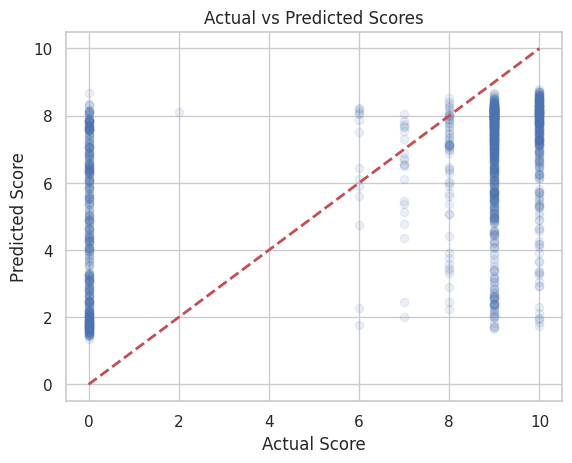

In [30]:
plt.scatter(y_val, pred_val_moe, alpha=0.1)
plt.plot([0, 10], [0, 10], 'r--', lw=2)
plt.ylabel("Predicted Score")
plt.xlabel("Actual Score")
plt.title("Actual vs Predicted Scores")
plt.show()

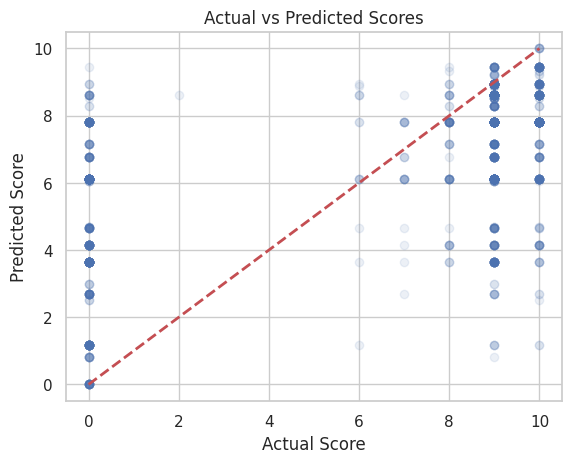

In [31]:
plt.scatter(y_val, pred_val_cal, alpha=0.1)
plt.plot([0, 10], [0, 10], 'r--', lw=2)
plt.ylabel("Predicted Score")
plt.xlabel("Actual Score")
plt.title("Actual vs Predicted Scores")
plt.show()

In [32]:
# ---------------------------------------------------------------
# Predict on test set
# ---------------------------------------------------------------
pred_low_t  = reg_low.predict(X_feat_test)
pred_mid_t  = reg_mid.predict(X_feat_test)
pred_high_t = reg_high.predict(X_feat_test)

pL_t, pM_t, pH_t = P_test[:,0], P_test[:,1], P_test[:,2]

pred_test_moe = pL_t * pred_low_t + pM_t * pred_mid_t + pH_t * pred_high_t
pred_test_cal = iso.transform(pred_test_moe)
pred_test_cal = np.clip(pred_test_cal, 0, 10)

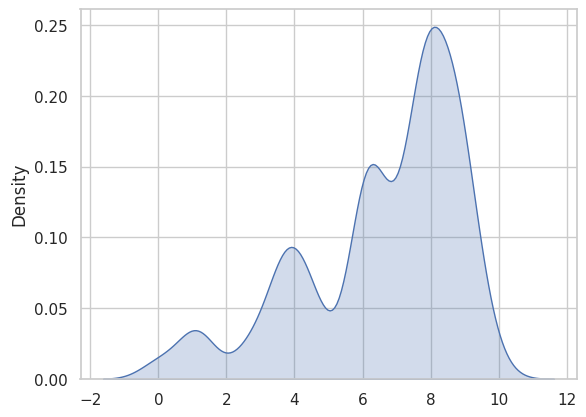

In [33]:
sns.kdeplot(pred_val_cal, fill=True)
plt.show()

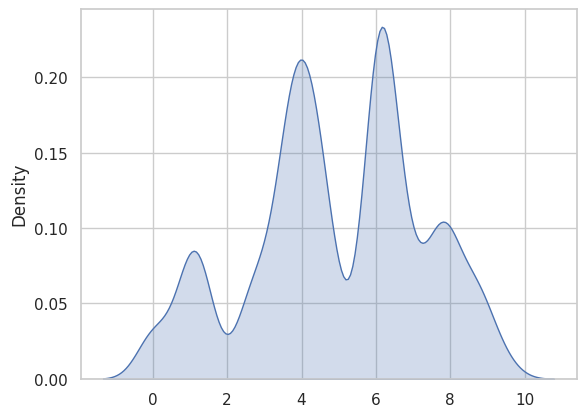

In [34]:
sns.kdeplot(pred_test_cal, fill=True)
plt.show()

In [35]:
# ---------------------------------------------------------------
# Save submission
# ---------------------------------------------------------------
df = pd.DataFrame({
    "ID": np.arange(1, len(X_test)+1),
    "score": np.round(pred_test_cal, 2)
})
df.to_csv("submission_me22b214.csv", index=False)

print("Saved: submission_me22b14.csv")

Saved: submission_me22b14.csv
